In [1]:
import tensorflow as tf
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
import neurokit2 as nk
import shap
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from scipy.signal import butter, filtfilt
import os

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Configuration
MODEL_PATH = "./model/model.keras"
RECORD_PATH = "../gmc2025/code15_wfdb/116"
DATASET_DIR = '../gmc2025/code15_wfdb/'
BALANCED_SAMPLES_DIR = "./BalancedSamples/"
REQUIRED_LENGTH = 1000
TARGET_FS = 100
NUM_ECGS = 100
SAVE_DIR = "./results/"
BEAT_WINDOW = (0.2, 0.4)  # seconds around R-peak

os.makedirs(SAVE_DIR, exist_ok=True)

In [20]:
def load_model(model_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    
    model = tf.keras.models.load_model(model_path, compile=False)
    return model

In [21]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal
    fs_ratio = target_fs / original_fs
    return signal.resample(original_signal, int(original_signal.shape[0] * fs_ratio))

In [22]:
def adjust_signal_length(signal, target_length):
    """Pad or truncate signal to target length"""
    if signal.shape[0] < target_length:
        return np.pad(signal, ((0, target_length - signal.shape[0]), (0, 0)), mode='constant')
    return signal[:target_length]

In [23]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [24]:
def compute_grad_cam(model, img_array, layer_name):
    # Create a grad model that outputs the conv layer and the final probability output.
    conv_layer = model.get_layer(layer_name)
    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        # Use final probability output
        class_output = preds[:, 0]
        # Now threshold on the probability directly
        class_idx = 1 if class_output > 0.5 else 0  
        grads = tape.gradient(class_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_output = conv_outputs[0] * pooled_grads

    heatmap = np.sum(conv_output.numpy(), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx

In [25]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, class_idx):
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    plt.suptitle(f"Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

In [26]:
def bandpass_filter(signal, lowcut=0.5, highcut=49.9, fs=100, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [27]:
#Helper
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')

def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

In [28]:
def get_chagas_label(text_extracted_from_signal):
    for comment in text_extracted_from_signal['comments']:
        if comment.startswith('Chagas label:'):
            label_str = comment.split(':')[-1].strip()  # Extract "False" or "True"
            break
    true_label = 1 if label_str == "True" else 0
    return true_label

In [29]:
def process_record(RECORD_PATH):
    try:
        ecg , fields= load_signals(RECORD_PATH)
        true_label = get_chagas_label(fields)
        fs = int(fields["fs"])

        resampled_signal = resample_signal(ecg, fs, TARGET_FS)
        adjusted_signal = adjust_signal_length(resampled_signal, REQUIRED_LENGTH)
        input_tensor = tf.convert_to_tensor(np.expand_dims(adjusted_signal, 0), dtype=tf.float32)
        
        return adjusted_signal, input_tensor, fields
    except Exception as main_error:
        print(f"Critical error: {str(main_error)}")

In [30]:
model = load_model(MODEL_PATH)
conv_layer_name = find_last_conv_layer(model)

In [31]:
adjusted_signal, input_tensor, fields = process_record(RECORD_PATH)

In [32]:
heatmap_original, class_idx_original = compute_grad_cam(model, input_tensor, conv_layer_name)

Original Signal - Predicted Class: 0


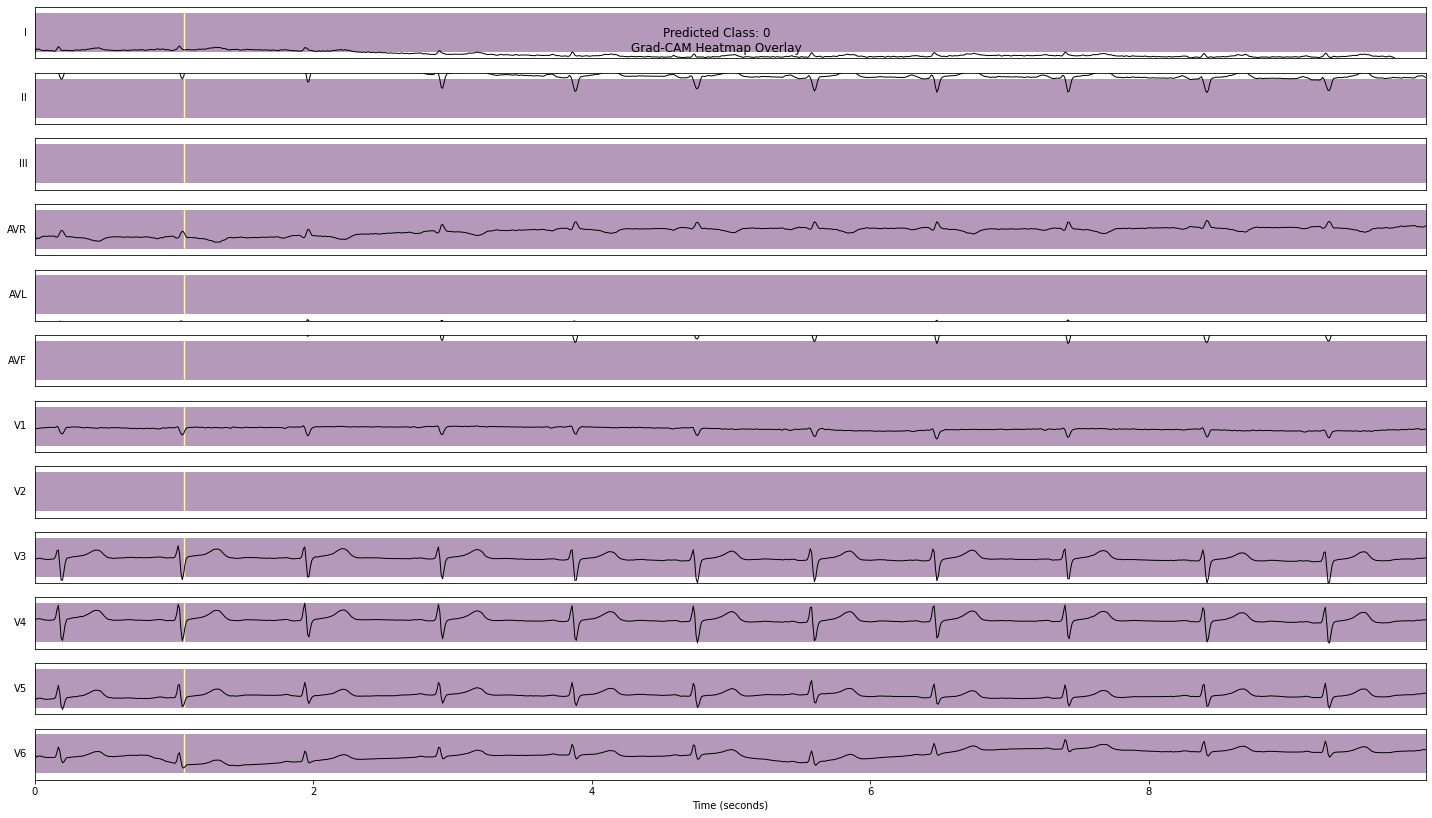

In [33]:
# Plot Grad-CAM
print(f"Original Signal - Predicted Class: {class_idx_original}")
plot_ecg_with_gradcam(
    adjusted_signal,
    heatmap_original,
    fields['sig_name'],
    TARGET_FS,
    class_idx=class_idx_original)

In [34]:
def load_all_records(dataset_path):
    records = set()  # to avoid duplicates

    for filename in os.listdir(dataset_path):
        if filename.endswith(".dat"):
            # Extract the record name (without the .dat extension)
            record_name = filename[:-4]
            records.add(record_name)

    sorted_record_names = sorted(records) # To make the same background using random seed
    
    return list(sorted_record_names)

In [35]:
def load_background_samples(dataset_path, num_samples=50):
    records = load_all_records(dataset_path)
    sampled_records = np.random.choice(records, num_samples, replace=False)
    background_samples = []
    
    for record in sampled_records:
        record_path = os.path.join(DATASET_DIR, record)
        signal, fields = load_signals(record_path)
        original_fs = int(fields['fs'])  # Get true sampling rate

        processed_signal = adjust_signal_length(
            resample_signal(signal, original_fs, TARGET_FS),
            REQUIRED_LENGTH)
        
        background_samples.append(processed_signal)
    
    return np.array(background_samples)

In [36]:
class LogitModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        # Reconstruct the complete computation graph
        self.input_layer = model.input
        self.feature_extractor = tf.keras.Model(
            inputs=model.input,
            outputs=model.layers[-2].output
        )
        
        # Explicitly create output layer with original weights (no activation)
        self.final_dense = tf.keras.layers.Dense(
            units=model.layers[-1].units,
            activation=None,
            use_bias=True,
            kernel_initializer=tf.constant_initializer(model.layers[-1].kernel.numpy()),
            bias_initializer=tf.constant_initializer(model.layers[-1].bias.numpy())
        )
        
        # Full computation graph
        self.logits = self.final_dense(self.feature_extractor(self.input_layer))
        
        # Create formal Model with defined inputs/outputs
        self.logit_model = tf.keras.Model(
            inputs=self.input_layer,
            outputs=self.logits
        )
        
    def call(self, x):
        return self.logit_model(x)
    
    @property
    def inputs(self):
        return self.logit_model.inputs
    
    @property
    def outputs(self):
        return self.logit_model.outputs

In [37]:
def compute_shap_explanations(model, adjusted_signal, lead_names, fs, class_idx):
    # Load background data
    background_samples = load_background_samples(DATASET_DIR)
    background = np.array(background_samples).astype(np.float32)
    
    # Verify background shape
    print("Background shape:", background.shape)  # Should be (50, 1000, 12)

    wrapped_model = LogitModel(model)
    
    # Initialize SHAP GradientExplainer
    explainer = shap.GradientExplainer(
        wrapped_model,
        background,
        batch_size=32
    )
    
    # Prepare input signal
    input_signal = adjusted_signal[np.newaxis, :, :].astype(np.float32)
    print("Input signal shape:", input_signal.shape)  # Should be (1, 1000, 12)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(input_signal)
    
    # Process and plot
    shap_heatmap = np.squeeze(shap_values[0])
    shap_heatmap_normalized = (shap_heatmap - np.min(shap_heatmap)) / (np.ptp(shap_heatmap) + 1e-8)
    plot_ecg_with_shap(adjusted_signal, shap_heatmap_normalized, lead_names, fs, class_idx)

In [38]:
def plot_ecg_with_shap(signal, heatmap, lead_names, fs, class_idx):
    if heatmap.shape != signal.shape:
        raise ValueError(f"Heatmap shape {heatmap.shape} doesn't match signal {signal.shape}")
    
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0])/fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        offset = lead * 3
        ax.plot(time, signal[:, lead] + offset, 'k', lw=1)
        ax.imshow(np.expand_dims(heatmap[:, lead], 0),
                  cmap='viridis',
                  aspect='auto',
                  extent=[time[0], time[-1], offset-2, offset+5],
                  alpha=0.4,
                  origin='lower')
        ax.set(ylabel=lead_names[lead], yticks=[], ylim=[offset-2, offset+2])
        if lead != num_leads-1:
            ax.set_xticks([])
    
    plt.suptitle(f"Class {class_idx} - SHAP Values", y=0.95)
    plt.tight_layout()
    plt.show()

Background shape: (50, 1000, 12)
Input signal shape: (1, 1000, 12)


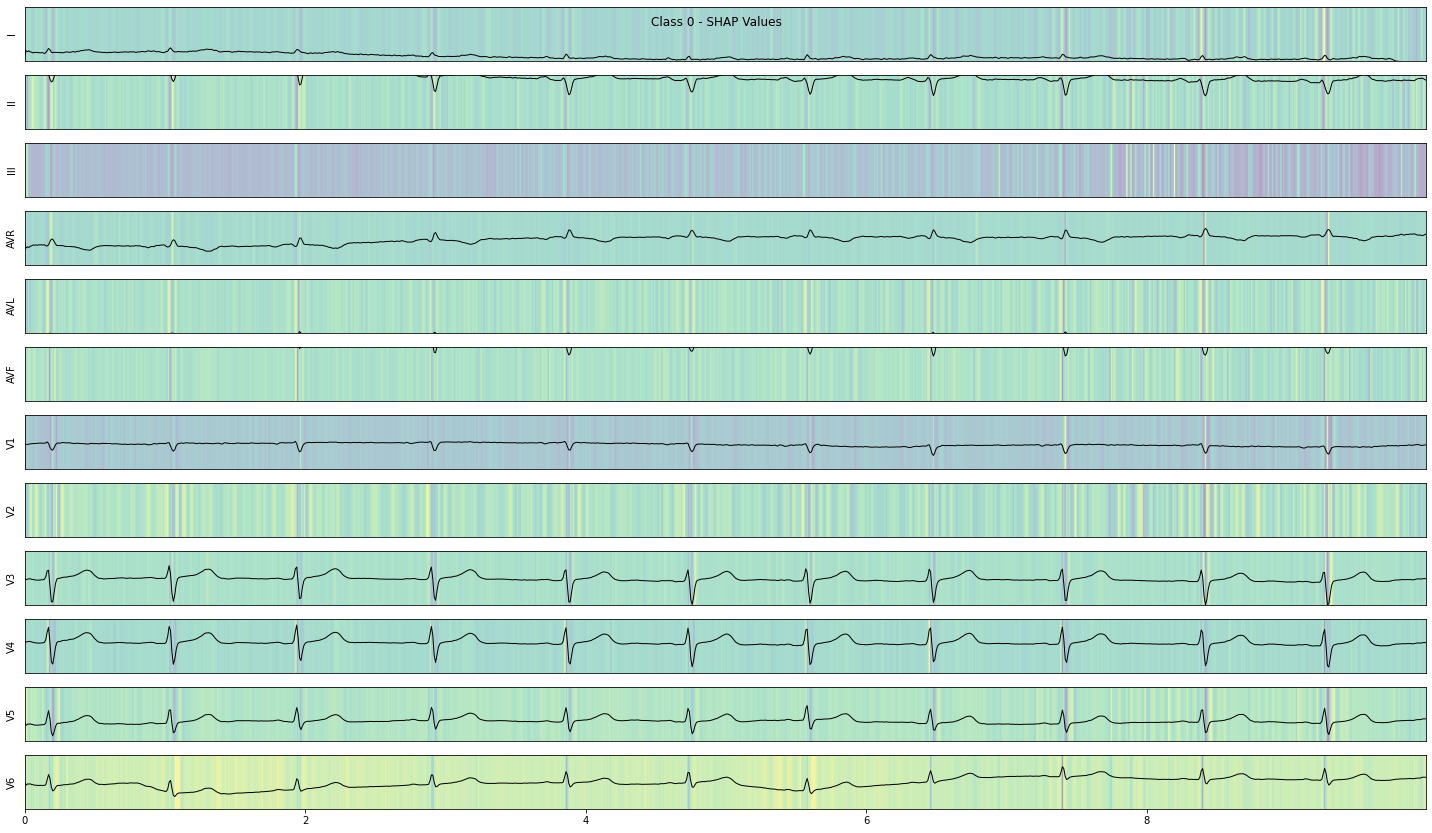

In [39]:
compute_shap_explanations(
    model=model,
    adjusted_signal=adjusted_signal,
    lead_names=fields['sig_name'],
    fs=TARGET_FS,
    class_idx=class_idx_original
)

In [40]:
probability_output = model.predict(input_tensor)

print("Predicted probabilities:", probability_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
Predicted probabilities: [[0.00045722]]


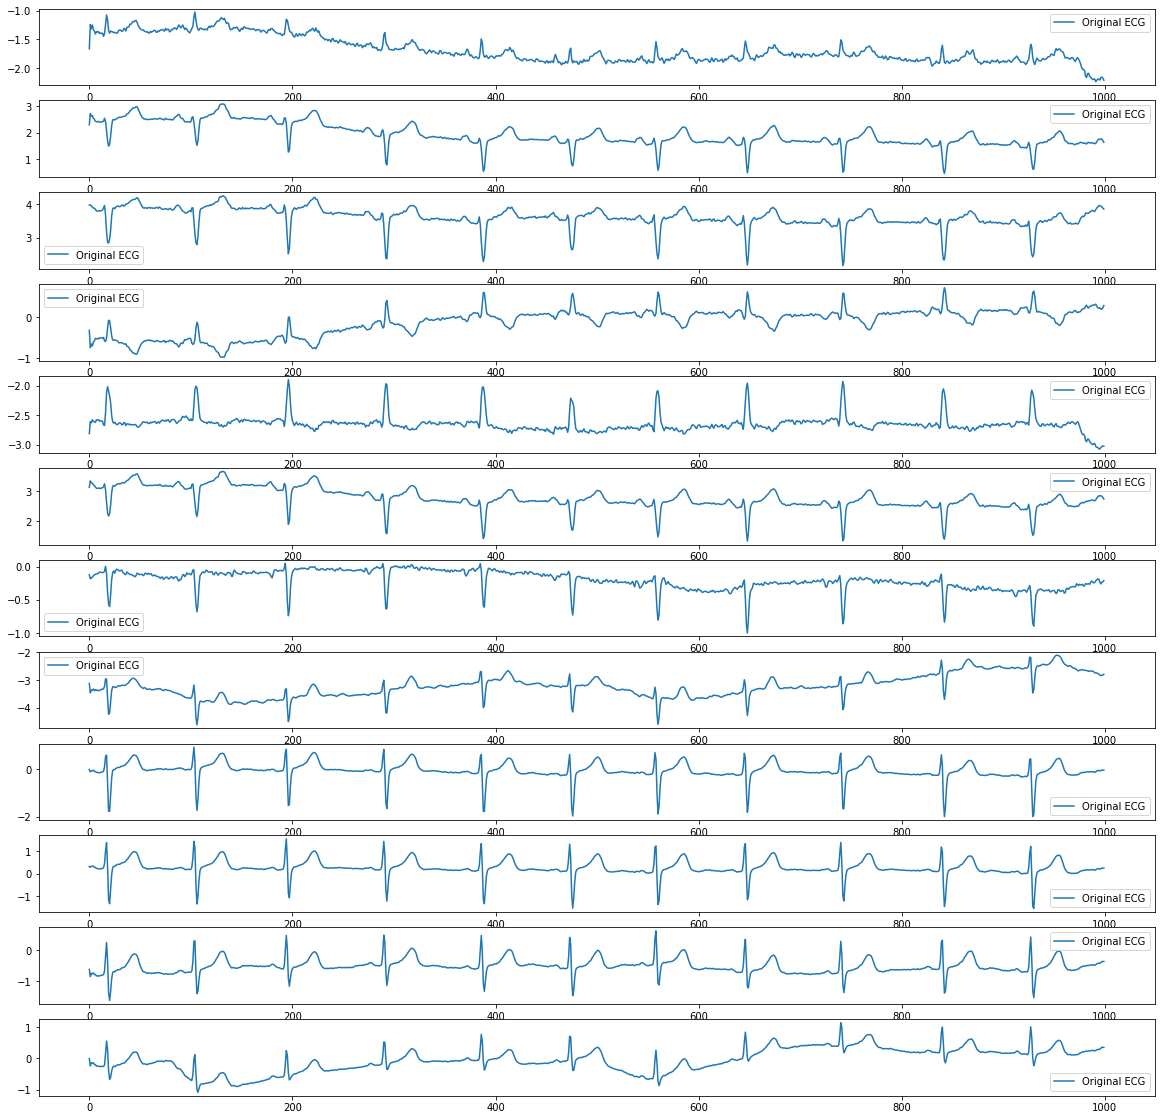

In [41]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(adjusted_signal)[:,i], label= "Original ECG")
    plt.legend()

In [42]:
def optimize_linear(grad, eps):
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    return scaled_perturbation

In [43]:
def pbga_attack(model,input_tensor,original_signal,target_class, max_iterations = 100, eps = 0.01, target_fs = TARGET_FS, verbose = True):

    adv_x = tf.identity(input_tensor)
    
    success = False

    for iteration in range(max_iterations):
        current_prob = model.predict(adv_x, verbose = 1 if verbose else 0)[0][0]
        
        # Early stopping if attack succeeds
        if (target_class == 0 and current_prob < 0.01) or \
           (target_class == 1 and current_prob > 0.8):
            if(verbose):
                print(f"Success at iteration {iteration}: Prob={current_prob:.4f}")
            success = True
            break

        with tf.GradientTape() as tape:
            tape.watch(adv_x)
            pred = model(adv_x)
            loss = tf.keras.losses.binary_crossentropy(
                tf.constant([[target_class]], dtype=tf.float32), 
                pred
            )
            loss = -loss  # Gradient ascent

        grads = tape.gradient(loss, adv_x)
        perturbation = optimize_linear(grads, eps)

        # Physiological filtering
        perturbation_filtered = np.array([
            bandpass_filter(perturbation[0,:,i], 
                          fs=target_fs, 
                          lowcut=0.5, 
                          highcut=49.9)
            for i in range(12)
        ])
        perturbation_filtered = np.expand_dims(perturbation_filtered.T, 0)

        adv_x = adv_x + perturbation_filtered
        
        # Maintain original signal range
        if original_signal is not None:
            adv_x = tf.clip_by_value(adv_x, np.min(original_signal), np.max(original_signal))

    return adv_x

In [44]:
adv_pbga = pbga_attack(
    model=model,
    input_tensor=input_tensor,
    original_signal=adjusted_signal,
    target_class= 1 - class_idx_original,
    eps=0.01,
    max_iterations=100,
    verbose = False
)

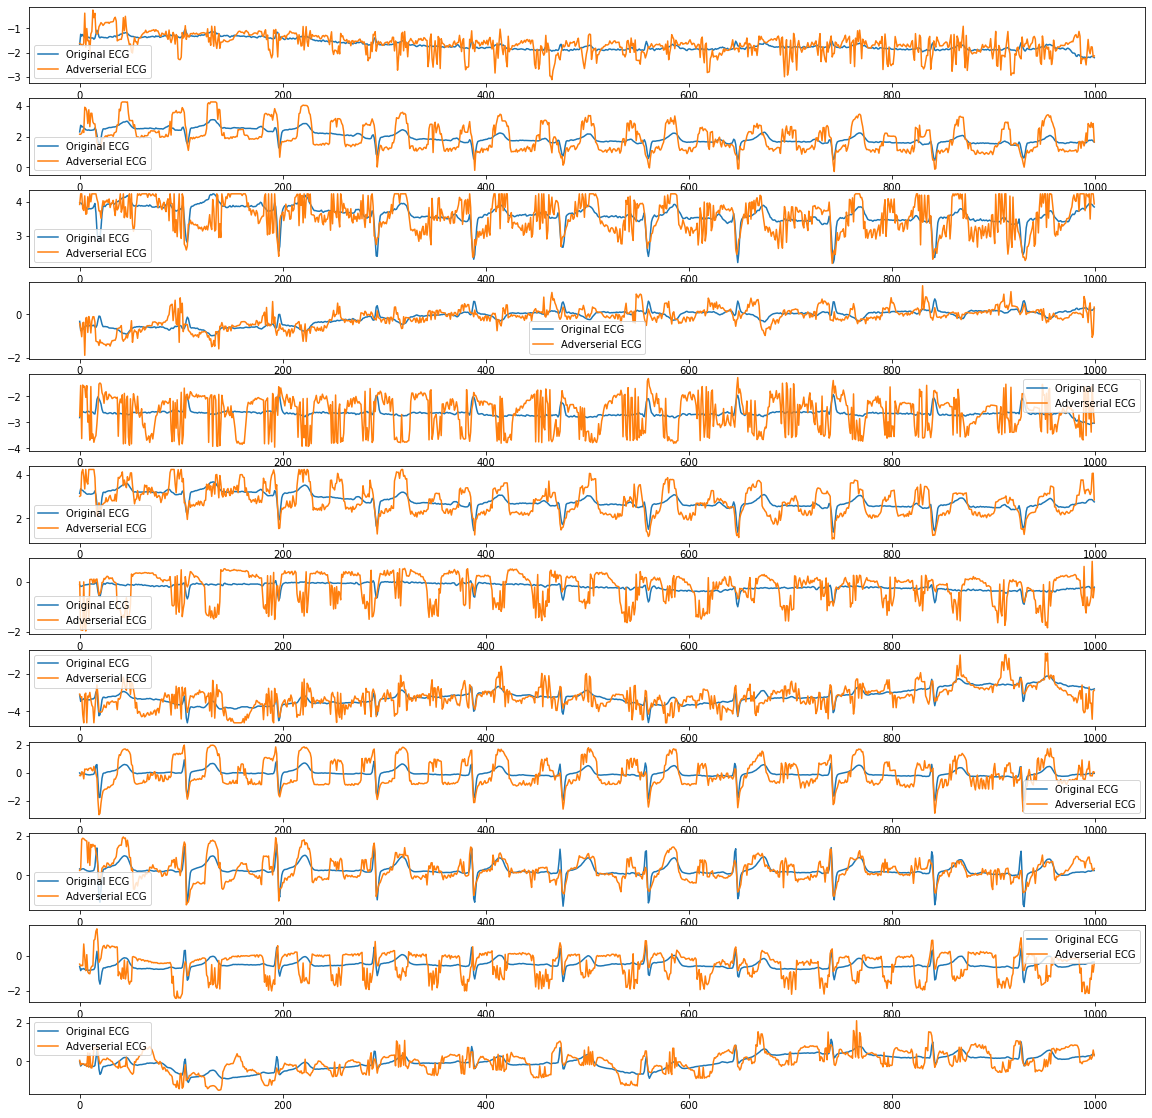

In [45]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(input_tensor)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_pbga)[0,:,i], label= "Adverserial ECG")
    plt.legend()

In [47]:
# Wrap the original model
wrapped_model = LogitModel(model)

In [48]:
# Custom Binary Loss Function
def binary_loss(labels, logits):
    return tf.nn.sigmoid_cross_entropy_with_logits(
        labels=labels,  # Shape (1, 1)
        logits=logits   # Shape (1, 1)
    )

Gradient Norm: 0.0011906843865290284


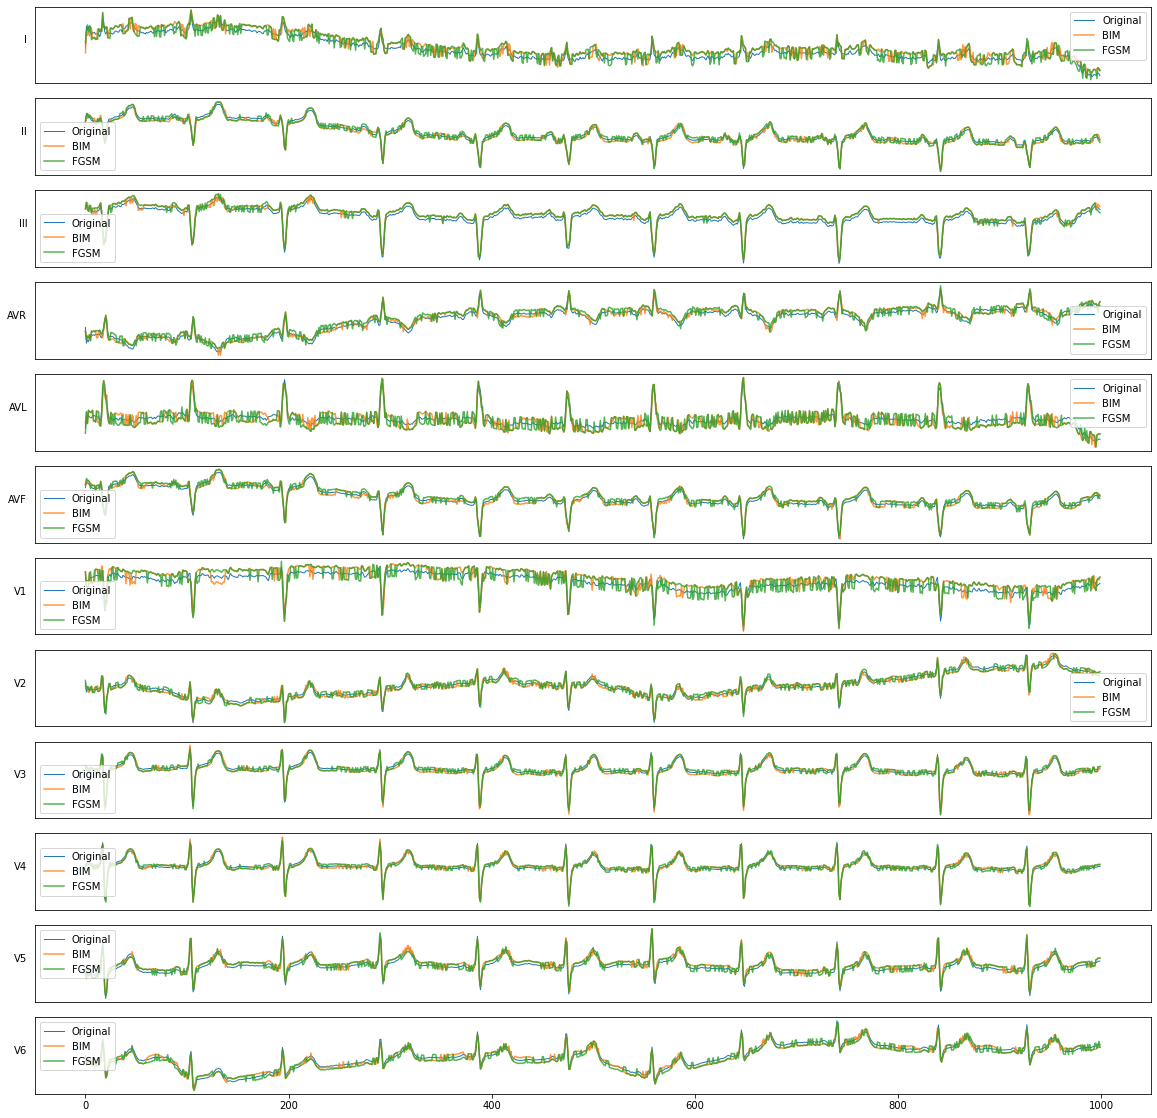

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Original: [[0.00045722]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
BIM: [[0.00108942]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
FGSM: [[0.00078306]]


In [54]:
target_class = 1 - class_idx_original
target_label_tf = tf.constant([[target_class]], dtype=tf.float32)

eps = 0.1  # perturbation size
alpha = 0.01  # step size
steps = 150  # attack steps

# Check gradient flow
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    logits = wrapped_model(input_tensor)
grads = tape.gradient(logits, input_tensor)
grad_norm = tf.reduce_mean(tf.abs(grads)).numpy()
print(f"Gradient Norm: {grad_norm}")  # Should not be too close to zero

if grad_norm < 1e-6:
    raise ValueError("Gradient vanishing! Check if the model is differentiable.")

# Generate adversarial examples

# Basic Iterative Method
adv_bim = projected_gradient_descent(
    wrapped_model,  # Use wrapped model
    input_tensor,
    eps,
    alpha,
    steps,
    norm=np.inf,
    y=target_label_tf,
    targeted=True,
    loss_fn=binary_loss,  # Use custom binary loss
)

adv_fgsm = fast_gradient_method(
    wrapped_model,  # Use wrapped logit model
    input_tensor,
    eps,
    norm=np.inf,
    y=target_label_tf,
    targeted=True,
    loss_fn=binary_loss
)

# Visualization
plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(12, 1, i+1)
    plt.plot(adjusted_signal[:, i], label="Original", linewidth=1)
    plt.plot(adv_bim.numpy()[0, :, i], label="BIM", alpha=0.8)
    plt.plot(adv_fgsm.numpy()[0, :, i], label="FGSM", alpha=0.8)
    plt.ylabel(fields['sig_name'][i], rotation=0, ha='right')
    plt.yticks([])
    if i != 11: plt.xticks([])
    plt.legend()
plt.show()

# Predictions
print("Original:", model.predict(input_tensor))
print("BIM:", model.predict(adv_bim))
print("FGSM:", model.predict(adv_fgsm))

In [55]:
def extract_median_beat(signal_lead, sampling_rate):
    """Extract median beat with error handling"""
    try:
        cleaned = nk.ecg_clean(signal_lead, sampling_rate=sampling_rate)
        peaks = nk.ecg_findpeaks(cleaned, sampling_rate=sampling_rate)
        rpeaks = peaks["ECG_R_Peaks"]
        
        if len(rpeaks) < 3:  # Need at least 3 beats for median
            return None

        # Extract beats with fixed window size
        window_pre = int(BEAT_WINDOW[0] * sampling_rate)
        window_post = int(BEAT_WINDOW[1] * sampling_rate)
        beats = []
        for r in rpeaks:
            start = r - window_pre
            end = r + window_post
            if start >= 0 and end <= len(cleaned):
                beats.append(cleaned[start:end])
        
        if len(beats) < 3:
            return None
            
        # Align beats to fixed length
        beat_length = window_pre + window_post
        aligned_beats = np.array([b[:beat_length] for b in beats if len(b) >= beat_length])
        if len(aligned_beats) == 0:
            return None
            
        return np.median(aligned_beats, axis=0)
    except Exception as e:
        print(f"Beat extraction error: {str(e)}")
        return None

In [56]:
# Generate adversarial examples dictionary
attacks = {
    "pbga" : adv_pbga,
    "bim": adv_bim,
    "fgsm" : adv_fgsm
}

In [57]:
def plot_all_leads_comparison(original_signal, attacks, fields, fs):
    num_leads = original_signal.shape[1]
    
    for attack_name, adv_example in attacks.items():
        adv_signal = adv_example.numpy()[0]  # Remove batch dimension
        
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle(f"Beat Morphology Comparison: {attack_name.upper()} Attack", y=0.99)
        gs = GridSpec(4, 3)  # 4 rows, 3 columns for 12 leads

        for lead_idx in range(num_leads):
            ax = fig.add_subplot(gs[lead_idx//3, lead_idx%3])
            lead_name = fields['sig_name'][lead_idx]
            
            try:
                # Original beat
                orig_beat = extract_median_beat(original_signal[:, lead_idx], fs)
                t_orig = np.arange(len(orig_beat)) / fs
                
                # Adversarial beat
                adv_beat = extract_median_beat(adv_signal[:, lead_idx], fs)
                t_adv = np.arange(len(adv_beat)) / fs
                
                # Plot both beats
                ax.plot(t_orig, orig_beat, label='Original', color='blue', lw=2)
                ax.plot(t_adv, adv_beat, label='Adversarial ' + attack_name, color='red', alpha=0.8, lw=1.5)
                
                ax.set_title(lead_name)
                ax.set_xlabel('Time (s)')
                ax.grid(True)
                if lead_idx == 0:  # Only show legend on first subplot
                    ax.legend()
                    
            except Exception as e:
                ax.set_title(f"{lead_name} - Error")
                ax.text(0.5, 0.5, "Beat extraction failed", 
                       ha='center', va='center', transform=ax.transAxes)
                continue

        plt.tight_layout()
        plt.show()

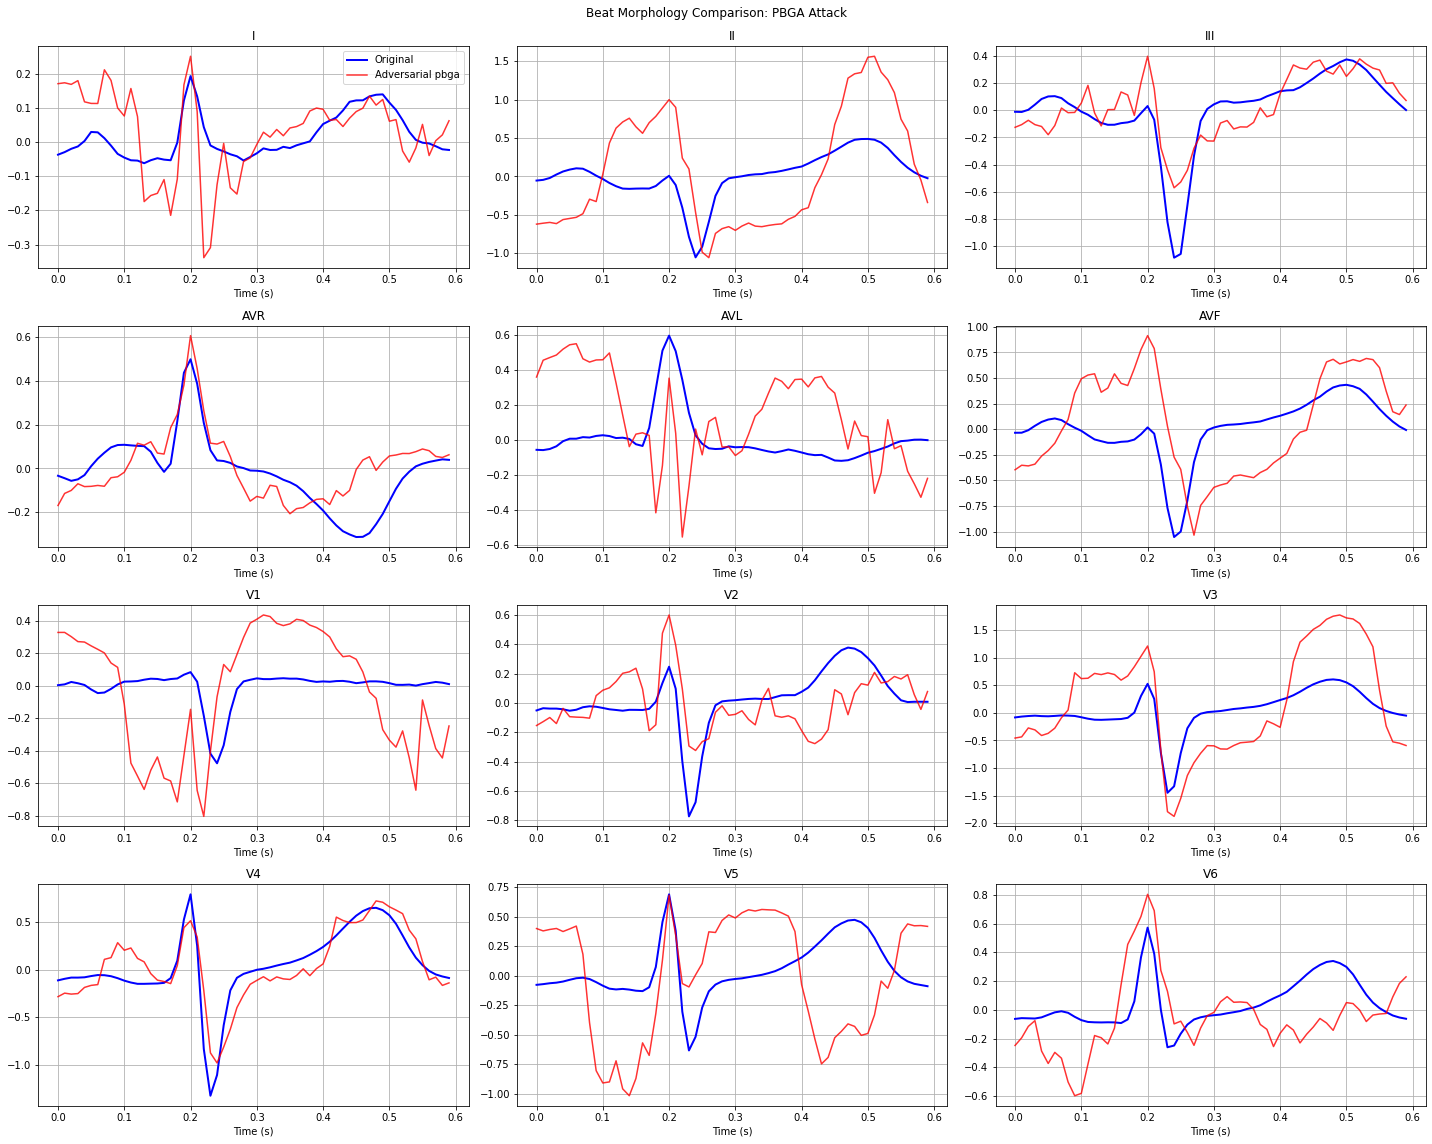

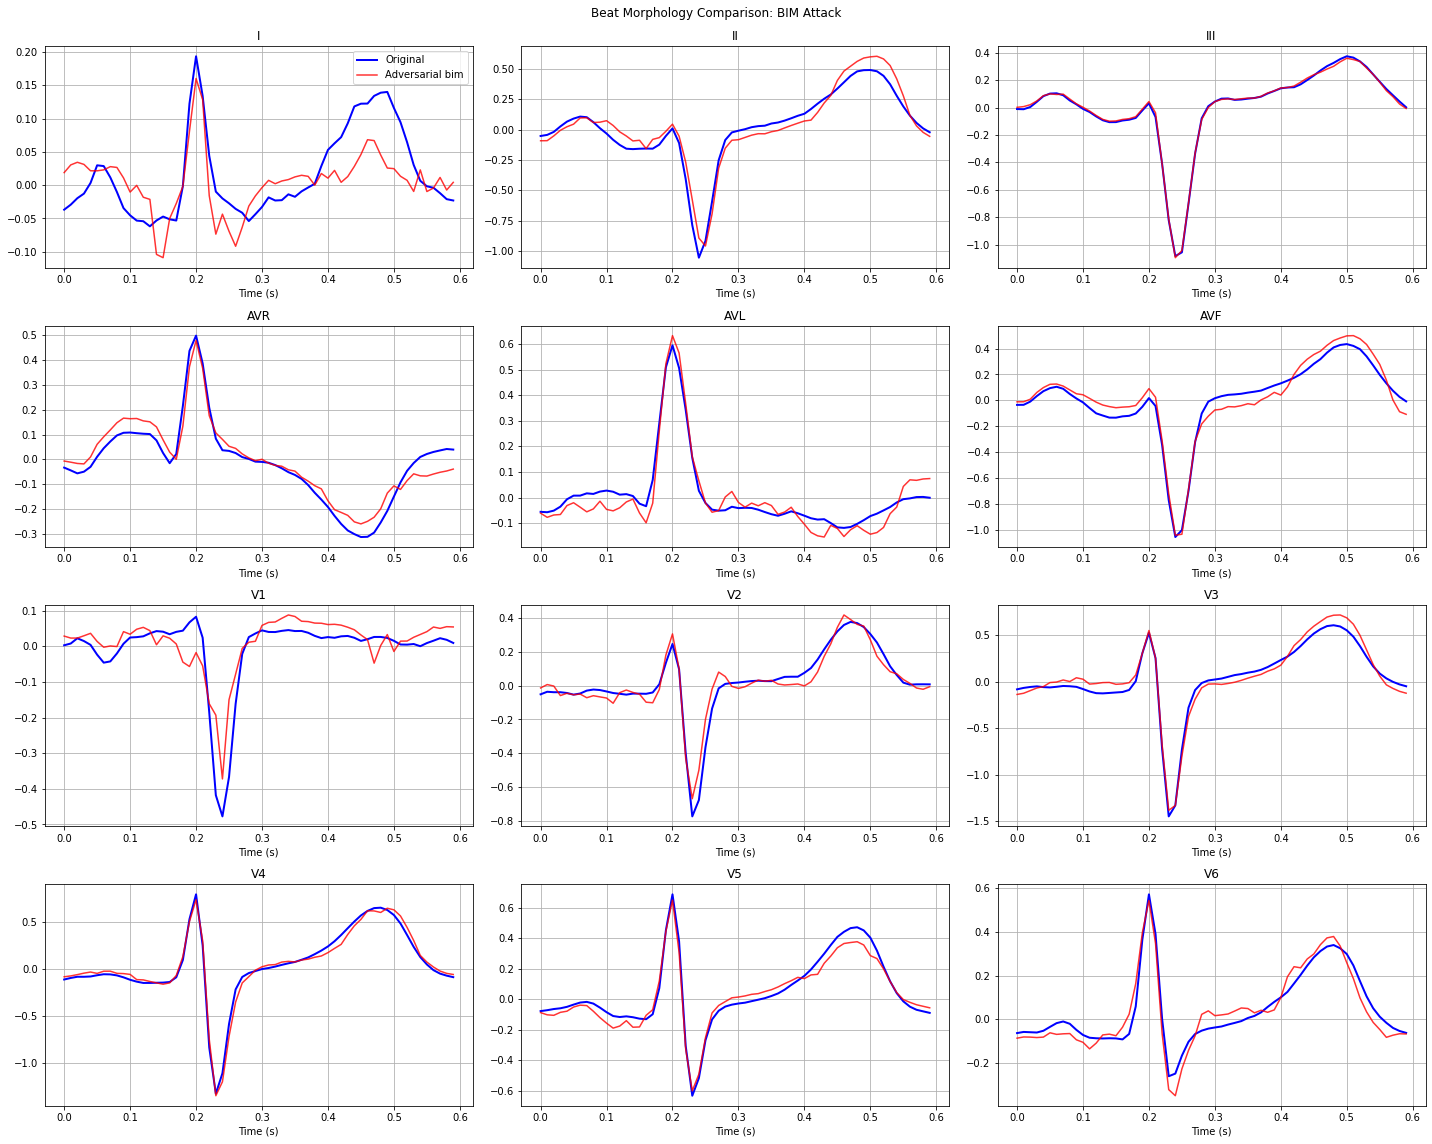

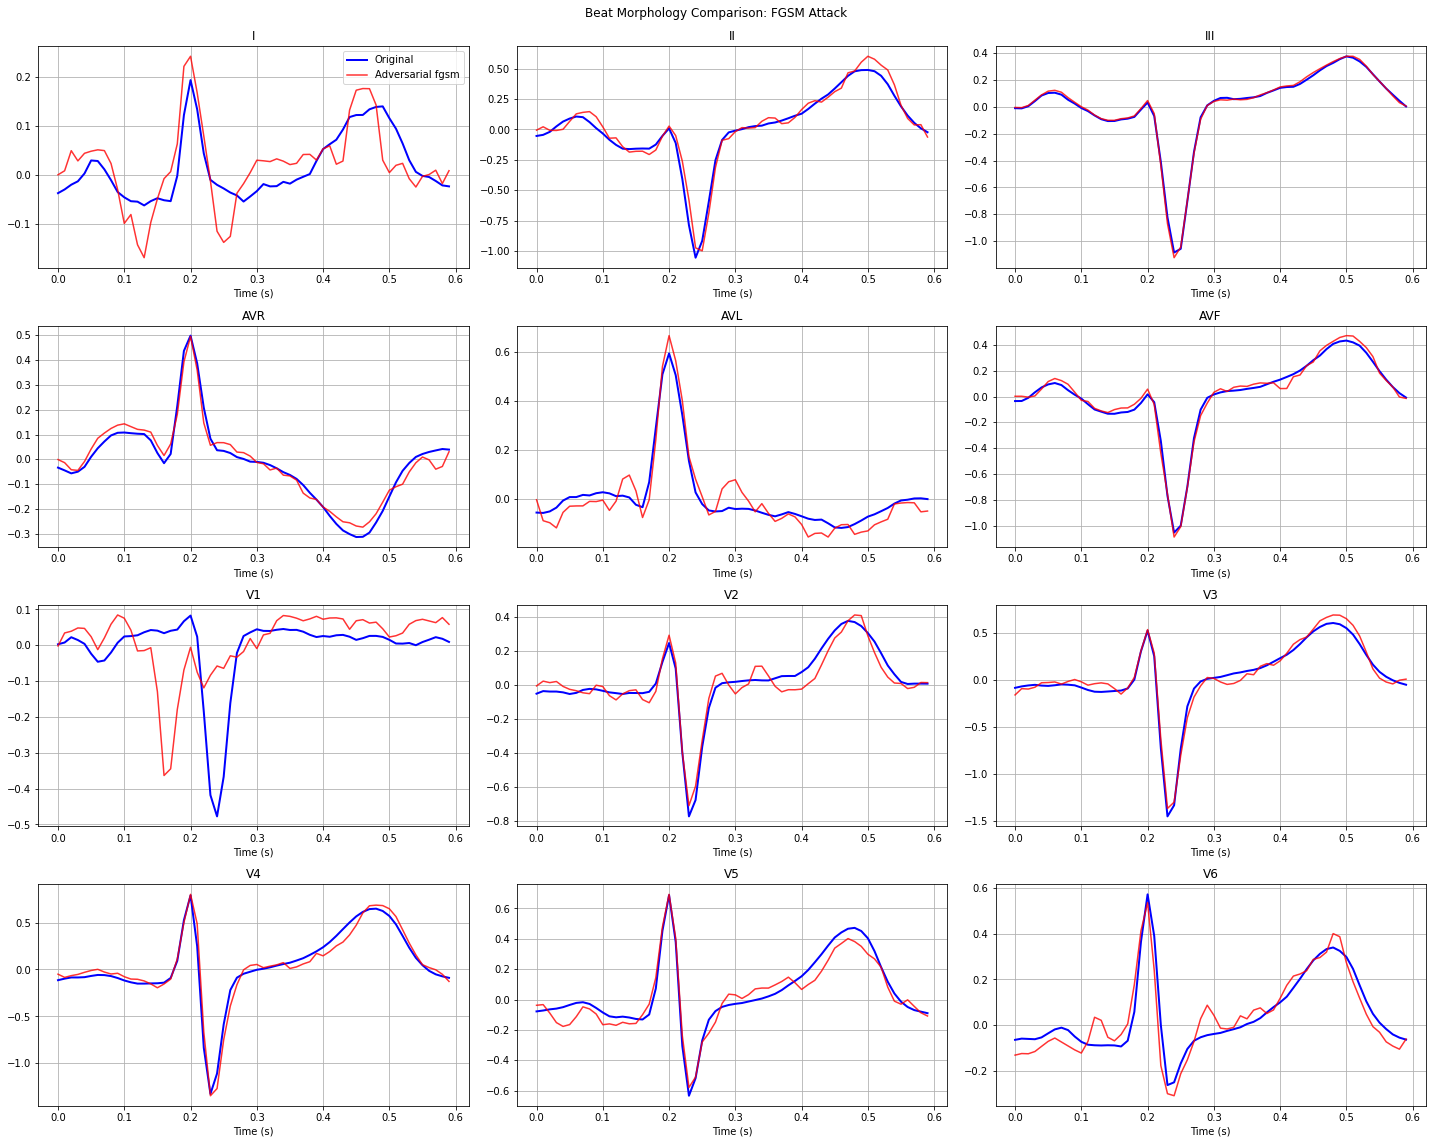

In [58]:
plot_all_leads_comparison(adjusted_signal, attacks, fields, TARGET_FS)

In [62]:
def process_ecg_batch(model, dataset_dir, num_ecgs=100, eps=0.1, alpha=0.01, steps=50):

    all_records = load_all_records(dataset_dir)
    
    if len(all_records) < num_ecgs:
        raise ValueError(f"Only {len(all_records)} records available, need {num_ecgs}")

    signal_len = int((BEAT_WINDOW[0] + BEAT_WINDOW[1]) * TARGET_FS)

    original_beats = np.full((num_ecgs, signal_len, 12), np.nan)
    adversarial_pbga_beats = np.full((num_ecgs, signal_len, 12), np.nan)
    adversarial_bim_beats = np.full((num_ecgs, signal_len, 12), np.nan)
    adversarial_fgsm_beats = np.full((num_ecgs, signal_len, 12), np.nan)
    
    metadata = []
    
    time_vector = np.linspace(-BEAT_WINDOW[0], BEAT_WINDOW[1], signal_len)

    processed_count = 0
    rng = np.random.default_rng(seed=42)
    wrapped_model = LogitModel(model)

    while processed_count < num_ecgs:
        if not all_records:
            raise RuntimeError("Exhausted all records before reaching target count")
            
        record = rng.choice(all_records, 1)[0]
        all_records.remove(record)
        
        try:
            adjusted_data = process_record(os.path.join(dataset_dir, record))
            if adjusted_data is None:
                continue
                
            adjusted_signal, input_tensor, fields = adjusted_data
            chagas_label = get_chagas_label(fields)
            
            orig_prob = model.predict(input_tensor, verbose=0)[0][0]
            target_class = 1 if orig_prob < 0.1 else 0
            target_label_tf = tf.constant([[target_class]], dtype=tf.float32)

            adv_pbga = pbga_attack(
                model,
                input_tensor,
                adjusted_signal,
                target_class, 
                max_iterations = 100, 
                eps = 0.01, 
                target_fs = TARGET_FS,
                verbose = False
            )

            adv_bim = projected_gradient_descent(
                wrapped_model,  # Use wrapped model
                input_tensor,
                eps,
                alpha,
                steps,
                norm=np.inf,
                y=target_label_tf,
                targeted=True,
                loss_fn=binary_loss,  # Use custom binary loss
            )
            
            adv_fgsm = fast_gradient_method(
                wrapped_model,  # Use wrapped logit model
                input_tensor,
                eps,
                norm=np.inf,
                y=target_label_tf,
                targeted=True,
                loss_fn=binary_loss
            )

            # Get predictions
            adv_pbga_prob = model.predict(adv_pbga, verbose=0)[0][0]
            adv_bim_prob = model.predict(adv_bim, verbose=0)[0][0]
            adv_fgsm_prob = model.predict(adv_fgsm, verbose=0)[0][0]

            # Process beats for each lead
            for lead in range(12):
                try:
                    # Original beat
                    orig_beat = extract_median_beat(adjusted_signal[:, lead], TARGET_FS)
                    if orig_beat is not None:
                        original_beats[processed_count, :len(orig_beat), lead] = orig_beat
                        
                    # PBGA beat
                    pbga_lead = adv_pbga.numpy()[0, :, lead]  # Correct tensor indexing
                    adv_pbga_beat = extract_median_beat(pbga_lead, TARGET_FS)
                    if adv_pbga_beat is not None:
                        adversarial_pbga_beats[processed_count, :len(adv_pbga_beat), lead] = adv_pbga_beat
                    
                    # BIM beat
                    bim_lead = adv_bim.numpy()[0, :, lead]  # Correct tensor indexing
                    adv_bim_beat = extract_median_beat(bim_lead, TARGET_FS)
                    if adv_bim_beat is not None:
                        adversarial_bim_beats[processed_count, :len(adv_bim_beat), lead] = adv_bim_beat
                        
                    # FGSM beat
                    fgsm_lead = adv_fgsm.numpy()[0, :, lead]
                    adv_fgsm_beat = extract_median_beat(fgsm_lead, TARGET_FS)
                    if adv_fgsm_beat is not None:
                        adversarial_fgsm_beats[processed_count, :len(adv_fgsm_beat), lead] = adv_fgsm_beat
                        
                except Exception as lead_error:
                    print(f"Lead {lead} error: {str(lead_error)}")
                    continue

            # Track success for both attacks
            pbga_success = (target_class == 0 and adv_pbga_prob < 0.1) or (target_class == 1 and adv_pbga_prob > 0.2)
            bim_success = (target_class == 0 and adv_bim_prob < 0.1) or (target_class == 1 and adv_bim_prob > 0.2)
            fgsm_success = (target_class == 0 and adv_fgsm_prob < 0.1) or (target_class == 1 and adv_fgsm_prob > 0.2)
            
            metadata.append({
                'index': processed_count,
                'record_name': record,
                'chagas_label': int(chagas_label),
                'original_prob': float(orig_prob),
                'adversarial_pbga_prob': float(adv_pbga_prob),
                'adversarial_bim_prob': float(adv_bim_prob),
                'adversarial_fgsm_prob': float(adv_fgsm_prob),
                'pbga_success': int(pbga_success),
                'bim_success': int(bim_success),
                'fgsm_success': int(fgsm_success)
            })
            
            processed_count += 1
            print(f"Processed {processed_count}/{num_ecgs} Original Probability: {orig_prob} | PBGA Probability {adv_pbga_prob} | PBGA: {pbga_success} | BIM Probability {adv_bim_prob} | BIM: {bim_success} | FGSM Probability {adv_fgsm_prob} | FGSM: {fgsm_success}\n")

        except Exception as ecg_error:
            print(f"Failed ECG {record}: {str(ecg_error)}")
            continue

    # Save results
    os.makedirs(SAVE_DIR, exist_ok=True)
    np.save(os.path.join(SAVE_DIR, 'time_vector.npy'), time_vector)
    np.save(os.path.join(SAVE_DIR, 'original_beats.npy'), original_beats)
    np.save(os.path.join(SAVE_DIR, 'adversarial_pbga_beats.npy'), adversarial_pbga_beats)
    np.save(os.path.join(SAVE_DIR, 'adversarial_bim_beats.npy'), adversarial_bim_beats)
    np.save(os.path.join(SAVE_DIR, 'adversarial_fgsm_beats.npy'), adversarial_fgsm_beats)
    pd.DataFrame(metadata).to_csv(os.path.join(SAVE_DIR, 'metadata.csv'), index=False)
    
    #return original_beats, adversarial_bim_beats, adversarial_fgsm_beats, metadata

In [68]:
process_ecg_batch(model, BALANCED_SAMPLES_DIR, num_ecgs=30, steps=250, eps=0.5,alpha=0.1)

Processed 1/30 Original Probability: 0.0006511711981147528 | PBGA Probability 0.8083356618881226 | PBGA: True | BIM Probability 0.7635703682899475 | BIM: True | FGSM Probability 0.0025990798603743315 | FGSM: False

Processed 2/30 Original Probability: 7.843344064895064e-06 | PBGA Probability 2.137094270437956e-05 | PBGA: False | BIM Probability 2.3271883037523367e-05 | BIM: False | FGSM Probability 1.6135087207658216e-05 | FGSM: False

Processed 3/30 Original Probability: 0.00023057375801727176 | PBGA Probability 0.8056004047393799 | PBGA: True | BIM Probability 0.9851388335227966 | BIM: True | FGSM Probability 0.00010316691623302177 | FGSM: False

Processed 4/30 Original Probability: 0.3699694573879242 | PBGA Probability 0.0044720787554979324 | PBGA: True | BIM Probability 5.689762360433884e-19 | BIM: True | FGSM Probability 0.00023078470258042216 | FGSM: True

Processed 5/30 Original Probability: 0.3361433148384094 | PBGA Probability 0.0064278459176421165 | PBGA: True | BIM Probabili

In [64]:
time_vector = np.load('./results/time_vector.npy')
original_beats = np.load('./results/original_beats.npy')
adversarial_pbga_beats = np.load('./results/adversarial_pbga_beats.npy')
adversarial_bim_beats = np.load('./results/adversarial_bim_beats.npy')
adversarial_fgsm_beats = np.load('./results/adversarial_fgsm_beats.npy')
metadata = pd.read_csv('./results/metadata.csv')

In [65]:
def plot_all_leads(
    record_idx,
    original_beats,
    adversarial_pbga_beats=None,
    adversarial_bim_beats=None,
    adversarial_fgsm_beats=None,
    leads=None,
    same_plot=False
):
    # Standard lead names and indices
    ALL_LEADS = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    # Validate leads to plot
    if leads is None:
        leads_to_plot = ALL_LEADS  # Plot all leads by default
    else:
        leads_to_plot = [lead for lead in leads if lead in ALL_LEADS]
        if not leads_to_plot:
            raise ValueError("No valid leads provided.")
    
    # Get indices of leads to plot
    lead_indices = [ALL_LEADS.index(lead) for lead in leads_to_plot]
    num_leads = len(lead_indices)
    
    # Process record indices
    if isinstance(record_idx, int):
        record_indices = [record_idx]
    else:
        record_indices = record_idx
    num_records = len(record_indices)
    
    # Configure adversarial beat types
    ADVERSARIAL_TYPES = [
        ('pbga', 'PBGA', 'r'),
        ('bim', 'BIM', 'b'),
        ('fgsm', 'FGSM', 'g')
    ]
    
    # Initialize containers
    beat_data = [original_beats]
    beat_types = ['Original']
    colors = ['k']  # Black for original
    line_styles = ['-', '--', ':', '-.']
    
    for suffix, name, color in ADVERSARIAL_TYPES:
        beat_var = locals().get(f'adversarial_{suffix}_beats')
        if beat_var is not None:
            beat_data.append(beat_var)
            beat_types.append(name)
            colors.append(color)
    
    num_beat_types = len(beat_data)
    
    # Create subplots with guaranteed 2D indexing
    total_rows = num_records * num_leads
    
    if same_plot:
        fig, axs = plt.subplots(
            total_rows, 1, 
            figsize=(15, 3 * total_rows), 
            squeeze=False,  # Force 2D array
        )
    else:
        fig, axs = plt.subplots(
            total_rows, 
            num_beat_types, 
            figsize=(5 * num_beat_types, 3 * total_rows), 
            squeeze=False,  # Force 2D array
        )
    
    # Set the suptitle to include all record indices
    plt.suptitle(f"ECG Leads Comparison (Records {', '.join(map(str, record_indices))})",y=1)
    
    # Plot for each record and lead
    for record_num, r_idx in enumerate(record_indices):
        for lead_plot_num, lead_idx in enumerate(lead_indices):
            lead_name = ALL_LEADS[lead_idx]
            row = record_num * num_leads + lead_plot_num
            
            if same_plot:
                ax = axs[row, 0]
                for bt_idx in range(num_beat_types):
                    ax.plot(
                        time_vector,
                        beat_data[bt_idx][r_idx, :, lead_idx],
                        color=colors[bt_idx],
                        linestyle=line_styles[bt_idx % len(line_styles)],
                        label=beat_types[bt_idx]
                    )
                ax.set_title(f"Record {r_idx}, Lead {lead_name}")
                ax.grid(True)
                ax.legend()
            else:
                for bt_idx in range(num_beat_types):
                    ax = axs[row, bt_idx]
                    ax.plot(
                        time_vector,
                        beat_data[bt_idx][r_idx, :, lead_idx],
                        color=colors[bt_idx]
                    )
                    ax.set_title(f"Record {r_idx}, {beat_types[bt_idx]} (Lead {lead_name})")
                    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

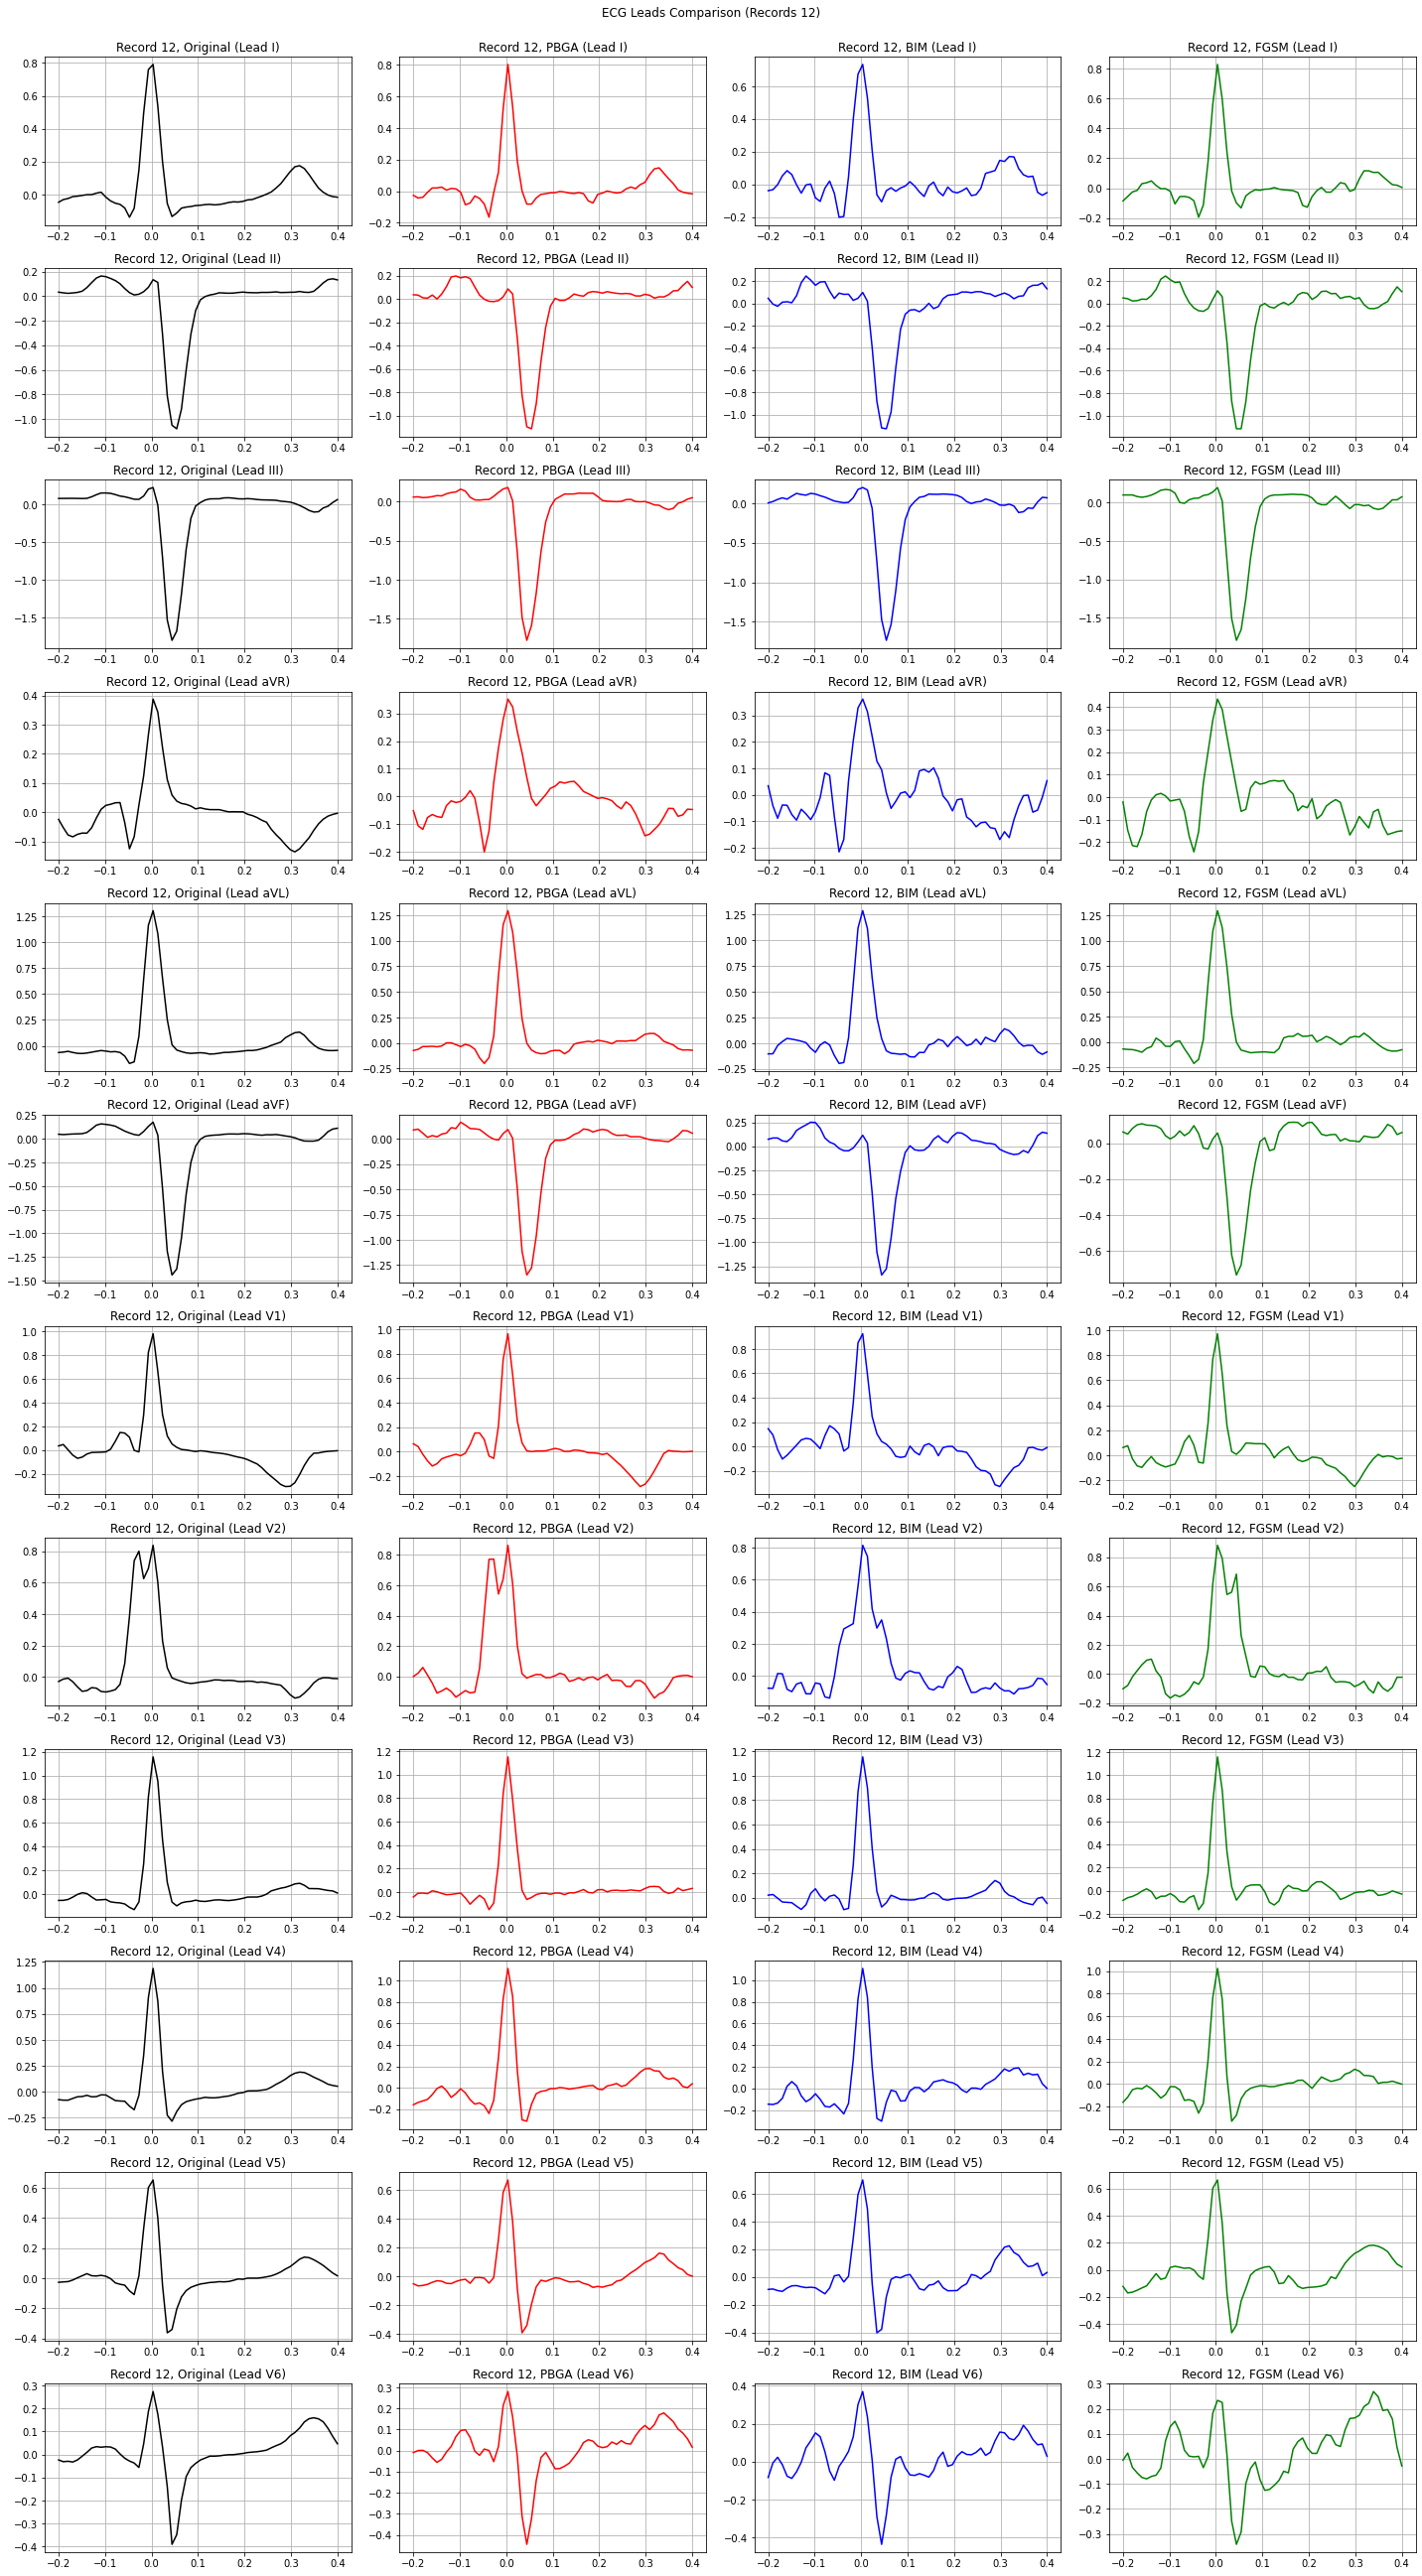

In [66]:
plot_all_leads(
    record_idx=[12],
    original_beats=original_beats,
    adversarial_pbga_beats=adversarial_pbga_beats,
    adversarial_bim_beats=adversarial_bim_beats,
    adversarial_fgsm_beats=adversarial_fgsm_beats,
    #leads=['V3'],
    same_plot=False
)